In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 31.9 MB/s 
     |████████████████████████████████| 86 kB 6.8 MB/s 
     |████████████████████████████████| 86 kB 7.8 MB/s 
     |████████████████████████████████| 212 kB 68.0 MB/s 
     |████████████████████████████████| 140 kB 70.4 MB/s 
     |████████████████████████████████| 1.1 MB 58.5 MB/s 
     |████████████████████████████████| 596 kB 66.5 MB/s 
     |████████████████████████████████| 127 kB 76.8 MB/s 
     |████████████████████████████████| 94 kB 4.5 MB/s 
     |████████████████████████████████| 271 kB 73.3 MB/s 
     |████████████████████████████████| 144 kB 51.9 MB/s 
     |████████████████████████████████| 112 kB 56.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing in

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 28.4 MB/s 
     |████████████████████████████████| 6.6 MB 60.3 MB/s 


In [3]:
from tqdm.auto import tqdm
import pandas as pd
from IPython.display import display
import torch
import numpy as np
import shutil
import os
import json
import gc
import datetime
import torch.nn as nn
from abc import ABC, abstractmethod
import torch.optim as optim
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.metrics import f1_score
import sklearn
import psutil  # RAM usage
import re
import random
import pickle
import datasets
import copy
from copy import deepcopy
import sys
from ast import literal_eval
from transformers import AutoTokenizer, AutoModel
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
import unicodedata

print(torch.__version__)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


1.11.0+cu113


In [4]:
from nltk.tokenize import RegexpTokenizer

punctuation = r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]?'
tok = RegexpTokenizer(r'\w+' + r'\w+?|[^\s]+?')

In [5]:
"""# Configs"""

class Dataset_info:
    def __init__(self, dataset_name, num_of_spans, max_span_length=5, ignore_classes=[], manual_text=None):
        self.dataset_name = dataset_name
        self.num_of_spans = num_of_spans
        self.ignore_classes = ignore_classes  # ignore other class in rel (semeval)
        self.manual_text = manual_text

POOL_METHOD = "attn"  # 'max', 'attn'
BATCH_SIZE = 32
#SEED = 0
LEARNING_RATE = 5e-5
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"

CACHE_LEN = 500
GPU_CACHE_LEN = 600  # 600
RAM_CACHE_LEN = 1500  # 2000

print(DEVICE)

def get_dataset_info(info1):
  info1 = info1.split('_')
  return '_'.join([info1[0], info1[0], info1[1]])

dataset_info_dict = {
    "lcc": Dataset_info("lcc_lcc_lcc", num_of_spans=1),
    "yulia": Dataset_info("yulia_yulia_yulia", num_of_spans=1),
    "wiktionary": Dataset_info("wiktionary_wiktionary_wiktionary", num_of_spans=1),
    "lcc_yulia": Dataset_info("lcc_lcc_yulia", num_of_spans=1),
    "lcc_wiktionary": Dataset_info("lcc_lcc_wiktionary", num_of_spans=1),
    "yulia_lcc": Dataset_info("yulia_yulia_lcc", num_of_spans=1),
    "yulia_wiktionary": Dataset_info("yulia_yulia_wiktionary", num_of_spans=1),
    "wiktionary_lcc": Dataset_info("wiktionary_wiktionary_lcc", num_of_spans=1),
    "wiktionary_yulia": Dataset_info("wiktionary_wiktionary_yulia", num_of_spans=1),
    "lcc_rusidio": Dataset_info("lcc_lcc_rusidio", num_of_spans=1),
    "yulia_rusidio": Dataset_info("yulia_yulia_rusidio", num_of_spans=1),
    "wiktionary_rusidio": Dataset_info("wiktionary_wiktionary_rusidio", num_of_spans=1),
}
for dname in ["lcc+yulia", "lcc+wiktionary", "lcc+yulia+wiktionary", "yulia+wiktionary"]:
  dataset_info_dict[dname+'_'+'rusidio'] = Dataset_info(get_dataset_info(dname+'_'+'rusidio'), num_of_spans=1)

cuda


In [ ]:
acc = s[5:6]
df = pd.read_csv('./drive/MyDrive/rscf/wiktionary/wiktionary_verb_examples.csv', index_col=0)
df = df.dropna()
dfs = [x for _, x in df.groupby(df['verblemma'])]
boths = []
for d in dfs:
  if d.Class.value_counts().shape[0] > 1:
    boths.append(d)
len(boths), sum([both.shape[0] for both in boths])
df = pd.concat(boths)
def get_spans(sent, wordform):
        try:
          s = sent.index(wordform)
          return [s, s+1]
        except:
          print(wordform, sent)
def get_folds(x):
        for fold, vbs in verbs.items():
          if x in vbs:
            return fold
def text_proc(x):
  x = x.replace(acc, '')
  return tok.tokenize(x)
df['wordforms'] = df.wordforms.apply(lambda x: x.replace(acc, ''))
df['text'] = df.sent.apply(text_proc)
df['span1'] = df.apply(lambda x: get_spans(x.text, x.wordforms), axis=1)
df = df.sample(frac=1)
train, test1 = train_test_split(df, test_size=0.3)
test, dev = train_test_split(test1, test_size=0.33)
train['fold'] = 'train'
dev['fold'] = 'dev'
test['fold'] = 'test'
df = pd.concat([train, dev, test])
df['label'] = df.Class.apply(lambda x: 'Metaphor' if x ==1 else 'Non-metaphor')
df['text'] = df.text.apply(' '.join)
df.to_csv('./drive/MyDrive/rscf/wiktionary/wiktionary_verb_examples_full.csv')

In [6]:
#python3 $EDGE_CODE xlm-roberta-base lcc_ru_ru 0
#DeepPavlov/rubert-base-cased-conversational
model_checkpoint = 'DeepPavlov/rubert-base-cased-conversational'
my_dataset_info = dataset_info_dict['lcc+yulia_rusidio']
# my_dataset_info_2 = dataset_info_dict[(sys.argv[2]).split('-')[1]]
SEED = 0
SEQ2SEQ_MODEL = "t5" in model_checkpoint or "pegasus" in model_checkpoint or "bart" in model_checkpoint
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed(SEED)

In [22]:
if "glove" in model_checkpoint:
    model = AutoModel.from_pretrained("bert-base-uncased")
else:
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True, do_lower_case=False)
    tokenizer.padding_side = 'right'
    model = AutoModel.from_pretrained(model_checkpoint)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
"""# Prepare Dataset & Spans"""

# model.save_pretrained(model_checkpoint)
# tokenizer.save_pretrained(model_checkpoint)

class Utils:
    def one_hot(idx, length):
        import numpy as np
        o = np.zeros(length, dtype=np.int8)
        o[idx] = 1
        return o

class Dataset_handler:
    def __init__(self, dataset_info: Dataset_info, selection = 'majority'):
        self.dataset = datasets.DatasetDict()
        self.tokenized_dataset = None
        self.dataset_info = dataset_info
        self.labels_list = None
        self.selection = selection
        # CACHE
        self.global_cache_counter = 0
        self.cache_last_hashable_input = ""
        
        if dataset_info.dataset_name == "lcc_lcc_lcc":
            frac = 1
            self.csv_to_dataset('./drive/MyDrive/metaphor-psycho/plm probing/ru/train.csv', data_type="train", fraction = frac)
            self.csv_to_dataset('./drive/MyDrive/metaphor-psycho/plm probing/ru/dev.csv', data_type="dev", fraction = frac)
            self.csv_to_dataset('./drive/MyDrive/metaphor-psycho/plm probing/ru/test.csv', data_type="test", fraction = frac)

        elif dataset_info.dataset_name == "yulia_yulia_yulia":
            frac = 1
            self.yulia_to_dataset('./drive/MyDrive/metaphor-psycho/verbs_with_wfs_full.csv', data_type="all", fraction = frac)
        elif dataset_info.dataset_name == "wiktionary_wiktionary_wiktionary":
            frac = 1
            self.yulia_to_dataset('./drive/MyDrive/rscf/wiktionary/wiktionary_verb_examples_full.csv', data_type="all", fraction = frac)
        elif dataset_info.dataset_name == "manual":
            frac = 1
            f = open("./manual_dataset.json", "w")
            f.write('{"text": "' + dataset_info.manual_text + '", "targets": [{"span1": [0, 0], "label": "' + my_dataset_handler.labels_list[0] + '"}]}')
            f.write('\n{"text": "' + dataset_info.manual_text + '", "targets": [{"span1": [0, 0], "label": "' + my_dataset_handler.labels_list[1] + '"}]}')
            f.close()
            self.json_to_dataset('./manual_dataset.json', data_type="train", fraction = frac, to_sentence_span=True)
            self.json_to_dataset('./manual_dataset.json', data_type="dev", fraction = frac, to_sentence_span=True)
            self.json_to_dataset('./manual_dataset.json', data_type="test", fraction = frac, to_sentence_span=True)
        else:
            #throw("Error: Unkown dataset name!")
            infos = dataset_info.dataset_name.split('_')
            frac=1
            for i, fold in enumerate(['train', 'dev', 'test']):
              if '+' in infos[i]:
                datas = []
                for info in infos[i].split('+'):
                  datas.append(self.any_to_dataset(info, fold=fold))
                self.dataset[fold] = datasets.concatenate_datasets(datas)
              else:
                self.any_to_dataset(infos[i], fold=fold)

        print("⌛ Tokenizing Dataset and Adding One Hot Representation of Labels")
        self.tokenized_dataset = self.tokenize_input_and_one_hot_labels(self.dataset)
        # self.tokenized_dataset = self.tokenize_dataset(self.dataset)
        # print("⌛ Adding One Hot Representation of Labels")
        # self.tokenized_dataset = self.one_hot_dataset_labels(self.tokenized_dataset)
        

    # Private:
    def merge_files(self, file_addresses: [], output_address: str):
        data = ""
        for file_address in file_addresses:
            with open(file_address) as fp:
                data += fp.read()
        with open (output_address, 'w') as fp:
            fp.write(data)

    def any_to_dataset(self, any, fold="train", frac=1):
      if any == 'lcc':
        return self.csv_to_dataset('./drive/MyDrive/metaphor-psycho/plm probing/ru/' + fold +'.csv', data_type=fold, fraction = frac)
      elif any == 'yulia':
        return self.yulia_to_dataset('./drive/MyDrive/metaphor-psycho/verbs_with_wfs_full.csv', data_type=fold, fraction = frac)
      elif any == 'wiktionary':
        return self.yulia_to_dataset('./drive/MyDrive/rscf/wiktionary/wiktionary_verb_examples_full.csv', data_type=fold, fraction = frac)
      elif any == 'rusidio':
        return self.rusidio_to_dataset('./drive/MyDrive/metaphor-psycho/metaphor_annotation_fpi/split1/', data_type=fold)

    def csv_to_dataset(self, csv_path, data_type="train", fraction=1):
      self.dataset[data_type] = datasets.Dataset.from_pandas(pd.read_csv(csv_path,converters={"span1": literal_eval}))
      return self.dataset[data_type]
    def yulia_to_dataset(self, csv_path, data_type="train", fraction=1):
      df = pd.read_csv(csv_path, converters={"span1": literal_eval}, index_col=0)
      '''verbs = {}
      verbs['train'] = ['бомбардировать', 'доить', 'греть', 'очертить', 'пилить', 'причесать', 'распылять',
            'разбавлять', 'съедать', 'трубить', 'уколоть', 'выкраивать', 'взорвать', 'жонглировать']
      verbs['dev'] = ['зажигать', 'нападать']
      verbs['test'] = ['утюжить', 'отрубить', 'подхватывать', 'взвесить']
      def get_spans(sent, wordform):
        try:
          s = sent.split().index(wordform.split('\'')[1])
          return [s, s+1]
        except:
          print(sent)
      def get_folds(x):
        for fold, vbs in verbs.items():
          if x in vbs:
            return fold
      df['fold'] = df.verblemma.apply(get_folds)      
      df['span1'] = df.apply(lambda x: get_spans(x.sent, x.wordforms), axis=1)
      df['label'] = df.Class.apply(lambda x: 'Metaphor' if x ==1 else 'Non-metaphor')
      '''
      if not ('text' in df.columns):
        df['text'] = df['sent']
      df['fold'] = df.fold.apply(lambda x: 'dev' if x == 'val' else x )
      if data_type=="all":
        for data_type in ['train', 'dev', 'test']:
          self.dataset[data_type] = datasets.Dataset.from_pandas(df[['text', 'span1', 'label']][df.fold == data_type])
      else:
          self.dataset[data_type] = datasets.Dataset.from_pandas(df[['text', 'span1', 'label']][df.fold == data_type])
      
      return self.dataset[data_type]
    def rusidio_to_dataset(self, foo, data_type='test'):
      selection = self.selection
      fns = os.listdir(foo)
      dfs = []
      def get_spans(sent, wordform):
        s = sent.split()
        try:
          s = s.index(wordform)
        except:
          print(wordform, '\t', s)
        return [s, s+1]
      if selection == 'majority':
        def maj(met_labels):
          if sum(met_labels) >= len(met_labels)/2.:
            return 'Metaphor'
          else:
            return 'Non-metaphor'
      for fn in fns:
        df = pd.read_excel(foo+fn, index_col=0)
        df['text_id'] = fn[:-5]
        if ('Elena_metaphor' in df.columns) and ('Victoria_metaphor' in df.columns) and ('Polina_metaphor' in df.columns):
          if selection == 'agree3':
            dfs.append(df[(df.Elena_metaphor == df.Victoria_metaphor) & (df.Victoria_metaphor == df.Polina_metaphor)])
          elif selection == 'agree2':
            dfs.append(df[df.Victoria_metaphor == df.Polina_metaphor])
          else:
             dfs.append(df)
      df = pd.concat(dfs)
      df['span1'] = df.apply(lambda x: get_spans(x.sent, x.verb), axis=1)
      df['text'] = df.sent
      #df['label'] = df.Elena_metaphor.apply(lambda x: 'Metaphor' if x == 1. else 'Non-metaphor')
      if selection.startswith('agree'):
        df['label'] = df.Polina_metaphor.apply(lambda x: 'Metaphor' if x == 1. else 'Non-metaphor')
      elif selection == 'majority':
        df['label'] = df.apply(lambda x: maj([x.Victoria_metaphor, x.Polina_metaphor, x.Elena_metaphor]), axis=1)
      else:
        df['label'] = df[selection +'_metaphor'].apply(lambda x: 'Metaphor' if x == 1. else 'Non-metaphor')
      if data_type=="test":
        self.dataset[data_type] = datasets.Dataset.from_pandas(df[['text_id', 'text', 'span1', 'label', 'verb', 'Polina_metaphor', 'Victoria_metaphor', 'Elena_metaphor']])
      return self.dataset[data_type]
    '''
    def json_to_dataset(self, json_path, data_type="train", fraction=1, ignore_classes=[], keep_order=False, sample_from_head=False, to_sentence_span=False):
        data_df = self.json_to_df(json_path, to_sentence_span)
        data_df = data_df[~data_df["label"].isin(ignore_classes)]
        if sample_from_head:
            data_df = data_df.head(int(len(data_df) * fraction))
        else:
            if keep_order:
                data_df = data_df.sample(frac=fraction, random_state=SEED).sort_index().reset_index(drop=True)
            else:
                data_df = data_df.sample(frac=fraction, random_state=SEED).reset_index(drop=True)
        self.dataset[data_type] = datasets.Dataset.from_pandas(data_df)
        return self.dataset
    '''    
    def tokenize_input_and_one_hot_labels(self, dataset):
        train_df = pd.DataFrame(dataset["train"]["label"], columns=['label'])
        dev_df = pd.DataFrame(dataset["dev"]["label"], columns=['label'])
        test_df = pd.DataFrame(dataset["test"]["label"], columns=['label'])
        self.labels_list = list(set(train_df["label"].unique()).union
                               (set(dev_df["label"].unique())).union
                               (set(test_df["label"].unique())))
        self.label_to_index = dict()
        for idx, l in enumerate(self.labels_list):
            self.label_to_index[l] = idx
        
        if "glove" in model_checkpoint or "elmo" in model_checkpoint:
            tokenized_one_hot_dataset = dataset.map(tokenize_and_one_hot_glove,
                                                    fn_kwargs={"label_to_index": self.label_to_index,
                                                            "labels_len": len(self.label_to_index),
                                                            "one_hot_func": Utils.one_hot,
                                                            "num_of_spans": self.dataset_info.num_of_spans
                                                            },
                                                    batched=False,
                                                    num_proc=None)
        else:
            tokenized_one_hot_dataset = dataset.map(tokenize_and_one_hot,
                                                    fn_kwargs={"label_to_index": self.label_to_index,
                                                            "labels_len": len(self.label_to_index),
                                                            "tokenizer": tokenizer,
                                                            "one_hot_func": Utils.one_hot,
                                                            "num_of_spans": self.dataset_info.num_of_spans
                                                            },
                                                    batched=False,
                                                    num_proc=None)
        return tokenized_one_hot_dataset

    # Preprocesses
    def lcc_preprocess(self, target, instance, json_path):
        # if "lcc" in self.dataset_info.dataset_name.split('-')[0] and "src" not in self.dataset_info.dataset_name:
        if "lcc" in json_path:    
            target["label"] = float(target["label"])
            if 0.0 <= target["label"] < 0.5:
                # target["label"] = "Non-metaphor"
                target["label"] = 0
            elif 1.5 < target["label"] <= 3.0:
                # target["label"] = "Metaphor"
                target["label"] = 1
            else:
                return None, None
        if "trofi" in json_path:    
            if target["label"]=='nonliteral':
                target["label"] = 1
            elif target["label"]=='literal':
                target["label"] = 0
    
    def lcc_src_concept_preprocess(self, target, instance):
        if self.dataset_info.dataset_name == "lcc_src_concept":
            target["span1"] = target["span2"]
            score = float(target["score"])
            if score >= 2:
                return target, instance
            else:
                return None, None
        return target, instance

    def hatexplain_preprocess(self, target, instance):
        return target, instance

    def hatexplain_fullspan_preprocess(self, target, instance):
        if self.dataset_info.dataset_name == "hatexplain-fullspan":
            instance["text"] = re.sub(r'[^A-Za-z0-9 ]+', '', instance["text"])  # Alphanumeric + Space
        return target, instance
    
    def lcc_src_target_concept_preprocess(self, target, instance):
        if self.dataset_info.dataset_name == "lcc_src_target_concept":
            target["label"] = "(" + target["label"] + "," + instance["targetConcept"] + ")"
        return target, instance
'''
    def json_to_df(self, csv_path, to_sentence_span=False):
        pre_processes = [self.lcc_preprocess]
        texts = list(dataset['text'])
        labels = []
        cache_ids = []
        spans = []
        for idx, text in enumerate(texts):
            if self.cache_last_hashable_input != repr(text):
                self.cache_last_hashable_input = repr(text)
                self.global_cache_counter += 1
            
            cache_ids.append(self.global_cache_counter)

            
            if "lcc" in csv_path:
                labels.append('1' if dataset['label'][idx]=='Metaphor' else '0')
            if "trofi" in csv_path:
                labels.append('1' if dataset['label'][idx]=='nonliteral' else '0')
            if "vua" in csv_path:
                labels.append('1' if dataset['label'][idx]==1 else '0')

            span_indices = dataset['span1'][idx]
            spans.append([
                                     int(span_indices.split(',')[0].split('[')[1]),
                                     int(span_indices.split(',')[1].split()[0].split(']')[0])
            ])
        
        dataset['label'] = labels
        dataset['cache_id'] = cache_ids
        dataset['span1'] = spans
        return dataset
'''

'\n    def json_to_df(self, csv_path, to_sentence_span=False):\n        pre_processes = [self.lcc_preprocess]\n        texts = list(dataset[\'text\'])\n        labels = []\n        cache_ids = []\n        spans = []\n        for idx, text in enumerate(texts):\n            if self.cache_last_hashable_input != repr(text):\n                self.cache_last_hashable_input = repr(text)\n                self.global_cache_counter += 1\n            \n            cache_ids.append(self.global_cache_counter)\n\n            \n            if "lcc" in csv_path:\n                labels.append(\'1\' if dataset[\'label\'][idx]==\'Metaphor\' else \'0\')\n            if "trofi" in csv_path:\n                labels.append(\'1\' if dataset[\'label\'][idx]==\'nonliteral\' else \'0\')\n            if "vua" in csv_path:\n                labels.append(\'1\' if dataset[\'label\'][idx]==1 else \'0\')\n\n            span_indices = dataset[\'span1\'][idx]\n            spans.append([\n                               

In [26]:
def tokenize_and_one_hot_glove(examples, **fn_kwargs):
    # tokenize and align spans
    one_hot_func = fn_kwargs["one_hot_func"]
    num_of_spans = fn_kwargs["num_of_spans"]
    tokenized_inputs = {"text": examples["text"].lower().split()}

    tokenized_inputs["span1"] = [examples["span1"][0], examples["span1"][1]]
    tokenized_inputs["span1_len"] = tokenized_inputs["span1"][1] - tokenized_inputs["span1"][0]
    if num_of_spans == 2:
        tokenized_inputs["span2"] = [examples["span2"][0], examples["span2"][1]]
        tokenized_inputs["span2_len"] = tokenized_inputs["span2"][1] - tokenized_inputs["span2"][0]
    # One hot
    label_to_index = fn_kwargs["label_to_index"]
    labels_len = fn_kwargs["labels_len"]
    tokenized_inputs["one_hot_label"] = one_hot_func(label_to_index[examples["label"]], labels_len)
    return tokenized_inputs

cached_tokenized_input = {}
cached_onehot = {}
def tokenize_and_one_hot(examples, **fn_kwargs):
    # tokenize and align spans
    thread_tokenizer = fn_kwargs["tokenizer"]
    one_hot_func = fn_kwargs["one_hot_func"]
    num_of_spans = fn_kwargs["num_of_spans"]
    
    if repr(examples["text"]) in cached_tokenized_input:
        tokenized_inputs = cached_tokenized_input[repr(examples["text"])]
    else:
        tokenized_inputs = thread_tokenizer(examples["text"].split(), is_split_into_words=True)  # Must be splitted for tokenizer to word_ids works fine. (test e-mail!)
        cached_tokenized_input[repr(examples["text"])] = tokenized_inputs
    def align_span(word_ids, start_word_id, end_word_id):
        span = [0, 0]
        if start_word_id not in word_ids:
            print("Warning: There is no", start_word_id, "in", word_ids, examples["text"].split(), examples["label"])
            print(start_word_id)
            start_word_id -= 1
        span[0] = word_ids.index(start_word_id)  # First occurance
        if end_word_id - 1 not in word_ids[::-1]:
            print("Warning: There is no", end_word_id - 1, "in", word_ids, examples["text"].split(), examples["label"])
            end_word_id -= 1
        span[1] = len(word_ids) - 1 - word_ids[::-1].index(end_word_id - 1) + 1  # Last occurance (+1 for open range)
        return span

    word_ids = tokenized_inputs.word_ids()
    tokenized_inputs["span1"] = align_span(word_ids, examples["span1"][0], examples["span1"][1])
    tokenized_inputs["span1_len"] = tokenized_inputs["span1"][1] - tokenized_inputs["span1"][0]
    if num_of_spans == 2:
        tokenized_inputs["span2"] = align_span(word_ids, examples["span2"][0], examples["span2"][1])
        tokenized_inputs["span2_len"] = tokenized_inputs["span2"][1] - tokenized_inputs["span2"][0]
    # One hot
    label_to_index = fn_kwargs["label_to_index"]
    labels_len = fn_kwargs["labels_len"]
    if examples["label"] in cached_onehot:
        tokenized_inputs["one_hot_label"] = cached_onehot[examples["label"]]
    else:
        tokenized_inputs["one_hot_label"] = one_hot_func(label_to_index[examples["label"]], labels_len)
        cached_onehot[examples["label"]] = tokenized_inputs["one_hot_label"]
    return tokenized_inputs

my_dataset_handler = Dataset_handler(my_dataset_info, selection = 'Polina');

⌛ Tokenizing Dataset and Adding One Hot Representation of Labels


  0%|          | 0/17387 [00:00<?, ?ex/s]

  0%|          | 0/2355 [00:00<?, ?ex/s]

  0%|          | 0/2643 [00:00<?, ?ex/s]

,text,span1,label,__index_level_0__,input_ids,token_type_ids,attention_mask,span1_len,one_hot_label
0,розваровываются богатства россии а капитал выв...,"[6, 7]",Non-metaphor,None,"[101, 9187, 51202, 355, 2956, 36751, 9965, 301...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1,"[1, 0]"
1,"Тем более, прецедент в историиуже есть – прихо...","[10, 11]",Metaphor,None,"[101, 4044, 1377, 128, 60598, 340, 3354, 15806...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,"[0, 1]"
2,д ... . Традиционные орнаменты на русских наро...,"[22, 23]",Metaphor,None,"[101, 348, 132, 132, 132, 132, 28643, 7113, 77...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,"[0, 1]"


,text_id,text,span1,label,verb,Polina_metaphor,Victoria_metaphor,Elena_metaphor,__index_level_0__,input_ids,token_type_ids,attention_mask,span1_len,one_hot_label
0,1RP2_nan_ж_0_повествование,Вот уже прошло двадцать четыре дня со дня моег...,"[3, 4]",Metaphor,прошло,1.0,1.0,1.0,0.0,"[101, 1337, 1034, 3554, 11839, 4312, 2988, 850...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1,"[0, 1]"
1,1RP2_nan_ж_0_повествование,"Первое время было тяжело , так как сложно жить...","[9, 10]",Non-metaphor,жить,0.0,0.0,0.0,1.0,"[101, 15217, 1210, 1035, 4794, 128, 927, 879, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,"[1, 0]"
2,1RP2_nan_ж_0_повествование,"Первое время было тяжело , так как сложно жить...","[16, 17]",Non-metaphor,ждут,0.0,0.0,0.0,2.0,"[101, 15217, 1210, 1035, 4794, 128, 927, 879, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,"[1, 0]"
3,1RP2_nan_ж_0_повествование,"Поначалу учеба всегда кажется легкой , нет так...","[4, 5]",Non-metaphor,кажется,0.0,0.0,0.0,3.0,"[101, 43082, 77612, 1583, 1965, 33033, 128, 10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,"[1, 0]"
4,1RP2_nan_ж_0_повествование,Хотя у меня есть задолженности по учебе и их я...,"[11, 12]",Non-metaphor,пытаюсь,0.0,0.0,0.0,4.0,"[101, 2630, 352, 1021, 999, 35869, 797, 70872,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1,"[1, 0]"


idx = 629
DatasetDict({
    train: Dataset({
        features: ['text', 'span1', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'span1_len', 'one_hot_label'],
        num_rows: 17387
    })
    dev: Dataset({
        features: ['text', 'span1', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'span1_len', 'one_hot_label'],
        num_rows: 2355
    })
    test: Dataset({
        features: ['text_id', 'text', 'span1', 'label', 'verb', 'Polina_metaphor', 'Victoria_metaphor', 'Elena_metaphor', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'span1_len', 'one_hot_label'],
        num_rows: 2643
    })
})
Original Spans: {'text_id': '56RP2_nan_ж_0_повествование', 'text': 'Так много всего интересного произошло за последний месяц .', 'span1': [4, 5], 'label': 'Non-metaphor', 'verb': 'произошло', 'Polina_metaphor': 0.0, 'Victoria_metaphor': 0.0, 'Elena_metaphor': 0.0, '__index_level_0__': 0.0}
Tokenized Spans:

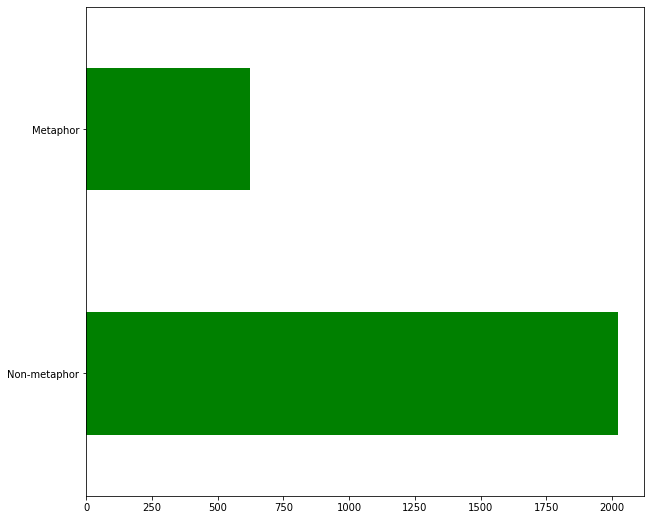

In [27]:
# Check
rnd_idx = np.random.randint(1000)
# rnd_idx = 58000
part = "test"
display(pd.DataFrame(my_dataset_handler.tokenized_dataset['train'][0:3]))
display(pd.DataFrame(my_dataset_handler.tokenized_dataset['test'][0:5]))
print("idx =", rnd_idx)
print(my_dataset_handler.tokenized_dataset)
print("Original Spans:", my_dataset_handler.dataset[part][rnd_idx])
print("Tokenized Spans:", my_dataset_handler.tokenized_dataset[part][rnd_idx])
if "glove" in model_checkpoint or "elmo" in model_checkpoint:
    test_tokens = my_dataset_handler.tokenized_dataset[part][rnd_idx]["text"]
else:
    test_tokens = tokenizer.convert_ids_to_tokens(my_dataset_handler.tokenized_dataset[part][rnd_idx]["input_ids"])
print(test_tokens)

s10, s11 = my_dataset_handler.tokenized_dataset[part][rnd_idx]["span1"][0], my_dataset_handler.tokenized_dataset[part][rnd_idx]["span1"][-1]
print("span1:", s10, s11, test_tokens[s10:s11])
if my_dataset_info.num_of_spans == 2:
    s20, s21 = my_dataset_handler.tokenized_dataset[part][rnd_idx]["span2"][0], my_dataset_handler.tokenized_dataset[part][rnd_idx]["span2"][-1]
    print("span2:", s20, s21, test_tokens[s20:s21])
print("label:", my_dataset_handler.tokenized_dataset[part][rnd_idx]["label"])

stats = pd.DataFrame(my_dataset_handler.tokenized_dataset[part]["label"], columns=['label'])["label"].value_counts()
print(stats.to_string())
print(list(stats.index))
print("|Labels| =", len(stats))
stats.plot(kind='barh', color="green", figsize=(10, 9));


In [28]:
"""# Edge Probe"""

class SpanRepr(ABC, nn.Module):
    """Abstract class describing span representation."""

    def __init__(self, input_dim, use_proj=False, proj_dim=256):
        super(SpanRepr, self).__init__()
        self.input_dim = input_dim  # embedding dim or proj dim
        self.proj_dim = proj_dim
        self.use_proj = use_proj

    @abstractmethod
    def forward(self, spans, attention_mask):
        """ 
        input:
            spans: [batch_size, layers, span_max_len, proj_dim/embedding_dim] ~ [32, 13, 4, 256]
            attention_mask: [batch_size, span_max_len] ~ [32, 4]
        returns:
            [32, 13, 256]
        """
        raise NotImplementedError

    def get_input_dim(self):
        return self.input_dim

class MaxSpanRepr(SpanRepr, nn.Module):
    """Class implementing the max-pool span representation."""

    def forward(self, spans, attention_mask):
        span_masks_shape = attention_mask.shape
        span_masks = attention_mask.reshape(
            span_masks_shape[0],
            1,
            span_masks_shape[1],
            1
        ).expand_as(spans)
        attention_spans = spans * span_masks - 1e10 * (1 - span_masks)

        max_span_repr, max_idxs = torch.max(attention_spans, dim=-2)
        return max_span_repr

class AttnSpanRepr(SpanRepr, nn.Module):
    """Class implementing the attention-based span representation."""

    def __init__(self, input_dim, use_proj=False, proj_dim=256, use_endpoints=False):
        """If use_endpoints is true then concatenate the end points to attention-pooled span repr.
        Otherwise just return the attention pooled term. (use_endpoints Not Implemented)
        """
        super(AttnSpanRepr, self).__init__(input_dim, use_proj=use_proj, proj_dim=proj_dim)
        self.use_endpoints = use_endpoints
        self.attention_params = nn.Linear(input_dim, 1)  # Learn a weight for each token: z(k)i = W(k)att e(k)i
        self.last_attention_wts = None

    def forward(self, spans, attention_mask):
        """ 
        input:
            spans: [batch_size, layers, span_max_len, proj_dim/embedding_dim] ~ [32, 13, 4, 256]
            attention_mask: [batch_size, span_max_len] ~ [32, 4]
        returns:
            [32, 13, 256]
        """
        span_masks_shape = attention_mask.shape
        span_masks = attention_mask.reshape(
            span_masks_shape[0],
            1,
            span_masks_shape[1],
            1
        ).expand_as(spans)
        attn_mask = - 1e10 * (1 - span_masks)

        attn_logits = self.attention_params(spans) + attn_mask  # Decreasing the attention of padded spans by -1e10
        attention_wts = nn.functional.softmax(attn_logits, dim=-2)
        attention_term = torch.sum(attention_wts * spans, dim=-2)

        self.last_attention_wts = attention_wts   # Save for later analysis

        return attention_term.float()

def get_span_module(input_dim, method="max", use_proj=False, proj_dim=256):
    """Initializes the appropriate span representation class and returns the object.
    """
    if method == "avg":
        return AvgSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "max":
        return MaxSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "diff":
        return DiffSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "diff_sum":
        return DiffSumSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "endpoint":
        return EndPointRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "coherent":
        return CoherentSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "coherent_original":
        return CoherentOrigSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "attn":
        return AttnSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim)
    elif method == "coref":
        return AttnSpanRepr(input_dim, use_proj=use_proj, proj_dim=proj_dim, use_endpoints=True)
    else:
        raise NotImplementedError

class Edge_probe_model(nn.Module):
    def __init__(self, num_of_spans, num_layers, input_span_len, embedding_dim, 
                 num_classes, pool_method='max', use_proj=True, proj_dim=256, 
                 hidden_dim=256, device='cuda', normalize_layers=False, use_cross_entropy=False):
        super(Edge_probe_model, self).__init__()
        self.device = device
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.num_of_spans = num_of_spans
        self.weighing_params = nn.Parameter(torch.ones(self.num_layers))
        self.input_dim = embedding_dim * num_of_spans
        self.use_proj = use_proj
        self.proj_dim = proj_dim
        self.normalize_layers = normalize_layers

        ## Projection
        if use_proj:
            # Apply a projection layer to output of pretrained models
            self.proj1 = nn.Linear(embedding_dim, proj_dim)
            if self.num_of_spans == 2:
                self.proj2 = nn.Linear(embedding_dim, proj_dim)
            # Update the input_dim
            self.input_dim = proj_dim * num_of_spans

        ## Pooling
        self.pool_method = pool_method
        input_dim = proj_dim if use_proj else embedding_dim
        self.span1_pooling_net = get_span_module(input_dim, method=pool_method).to(device)
        if self.num_of_spans == 2:
            self.span2_pooling_net = get_span_module(input_dim, method=pool_method).to(device)

        ## Classification
        label_net_list = [
            nn.Linear(self.input_dim, hidden_dim),
            nn.Tanh(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, self.num_classes)        
        ]
        if use_cross_entropy:
            self.training_criterion = nn.CrossEntropyLoss()
        else:
            self.training_criterion = nn.BCELoss()
            label_net_list.append(nn.Sigmoid())

        self.label_net = nn.Sequential(*label_net_list)
        self.optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE, weight_decay=0)

    def forward(self, spans_torch_dict):
        span1_reprs = spans_torch_dict["span1"]
        span1_attention_mask = spans_torch_dict["span1_attention_mask"]
        if self.num_of_spans == 2:
            span2_reprs = spans_torch_dict["span2"]
            span2_attention_mask = spans_torch_dict["span2_attention_mask"]
        
        ## Projection
        if self.use_proj:
            span1_reprs = self.proj1(span1_reprs)
            if self.num_of_spans == 2:
                span2_reprs = self.proj2(span2_reprs)
        
        ## Pooling
        pooled_span1 = self.span1_pooling_net(span1_reprs, span1_attention_mask)
        if self.num_of_spans == 2:
            pooled_span2 = self.span2_pooling_net(span2_reprs, span2_attention_mask)

        if self.normalize_layers:
            pooled_span1 = torch.nn.functional.normalize(pooled_span1, dim=-1)
            if self.num_of_spans == 2:
                pooled_span2 = torch.nn.functional.normalize(pooled_span2, dim=-1)

        if self.num_of_spans == 2:
            output = torch.cat((pooled_span1, pooled_span2), dim=-1)
        elif self.num_of_spans == 1:
            output = pooled_span1
        # print(output.shape)  # torch.Size([32, 13, 512])

        ## Mixing Weights
        wtd_encoded_repr = 0
        soft_weight = nn.functional.softmax(self.weighing_params, dim=0)
        for i in range(self.num_layers):
            wtd_encoded_repr += soft_weight[i] * output[:, i, :]
        output = wtd_encoded_repr

        ## Classification
        pred_label = self.label_net(output)
        pred_label = torch.squeeze(pred_label, dim=-1)
        return pred_label

    def summary(self, do_print=True):
        summary_str = str(self)
        pytorch_total_params = sum(p.numel() for p in self.parameters())
        pytorch_total_params_trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        summary_str += f"\n Total Parameters:     {pytorch_total_params}"
        summary_str += f"\n Trainable Parameters: {pytorch_total_params_trainable}"
        summary_str += f"\n Pool Method: {self.pool_method}"
        summary_str += f"\n Projection: {self.use_proj}, {self.proj_dim}"
        summary_str += f"\n normalize_layers: {self.normalize_layers}"
        if do_print:
            print(summary_str)
        return summary_str


In [29]:
gpu_cache = dict()
ram_cache = dict()
class Trainer(ABC):
    """ Abstract Trainer Class """
    def span_dict_to_device(self, spans_torch_dict, device="cuda"):
        new_dict = copy.deepcopy(spans_torch_dict)
        new_dict["span1"] = new_dict["span1"].to(device)
        new_dict["span1_attention_mask"] = new_dict["span1_attention_mask"].to(device)
        if self.num_of_spans == 2:
            new_dict["span2"] = new_dict["span2"].to(device)
            new_dict["span2_attention_mask"] = new_dict["span2_attention_mask"].to(device)
        return new_dict

    def prepare_batch_data(self, tokenized_dataset, start_idx, end_idx, pad=False, cache_prefix=None):
        if cache_prefix is not None:
            cache_id = f"{cache_prefix}{start_idx}-{end_idx}"
            if cache_id in gpu_cache:
                return gpu_cache[cache_id]
            if cache_id in ram_cache:
                return self.span_dict_to_device(ram_cache[cache_id], "cuda")

        span_representations_dict = self.extract_embeddings(tokenized_dataset, start_idx, end_idx, pad=True)
        span1_torch = torch.stack(span_representations_dict["span1"]).float().to(self.MLP_device)  # (batch_size, #layers, max_span_len, embd_dim)
        span1_attention_mask_torch = torch.stack(span_representations_dict["span1_attention_mask"])
        one_hot_labels_torch = torch.tensor(np.array(span_representations_dict["one_hot_label"]))
        if self.num_of_spans == 2:
            span2_torch = torch.stack(span_representations_dict["span2"]).float().to(self.MLP_device)
            span2_attention_mask_torch = torch.stack(span_representations_dict["span1_attention_mask"])
            spans_torch_dict = {"span1": span1_torch, 
                                "span2": span2_torch, 
                                "span1_attention_mask": span1_attention_mask_torch, 
                                "span2_attention_mask": span2_attention_mask_torch, 
                                "one_hot_labels": one_hot_labels_torch}
        elif self.num_of_spans == 1:
            spans_torch_dict = {"span1": span1_torch, 
                                "span1_attention_mask": span1_attention_mask_torch, 
                                "one_hot_labels": one_hot_labels_torch}

        if cache_prefix is not None:
            if len(gpu_cache) < GPU_CACHE_LEN:
                gpu_cache[cache_id] = spans_torch_dict
                print(cache_id, end="|")
            elif len(ram_cache) < RAM_CACHE_LEN:
                ram_cache[cache_id] = self.span_dict_to_device(spans_torch_dict, "cpu")
                print(cache_id, end=",")
        return spans_torch_dict

    def get_language_model_properties(self):
        span_representations_dict = self.extract_embeddings(self.dataset_handler.tokenized_dataset["train"], 0, 3, pad=True)
        for i in span_representations_dict["span1"]:
            print(i.shape)
        span1_torch = span_representations_dict["span1"]
        num_layers = span1_torch[0].shape[0]
        span_len = span1_torch[0].shape[1]
        embedding_dim = span1_torch[0].shape[2]
        return num_layers, span_len, embedding_dim, len(self.dataset_handler.labels_list)

    def pad_span(self, span_repr, max_len):
        """ pad spans in embeddings to max_len 
        input:
            span_representation: df with shape (#layers, span_len, embedding_dim)
        returns:
            padded_spans: np with shape (batch_len, num_layers, max_len, embedding_dim)
            attention_mask: np with shape (max_len), values = 1: data, 0: padding
        """
        shape = span_repr.shape
        num_layers = shape[0]
        span_original_len = shape[1]
        embedding_dim = shape[2]
        attention_mask = torch.ones(max_len, dtype=torch.int8, device=self.device)
        attention_mask[span_original_len:] = 0

        padded_span_repr = torch.cat((span_repr, torch.zeros((num_layers, max_len - span_original_len, embedding_dim), device=self.device)), axis=1)
        return padded_span_repr, attention_mask

    def init_span_dict(self, num_of_spans, pad):
        if num_of_spans == 2:
            span_repr = {"span1": [], "span2": [], "label": [], "one_hot_label": []}
        else:
            span_repr = {"span1": [], "label": [], "one_hot_label": []}
        
        if pad:
            span_repr["span1_attention_mask"] = []
            span_repr["span2_attention_mask"] = []
        return span_repr

    def extract_glove(self, tokenized_dataset, idx, span_start, span_end):
        text = tokenized_dataset[idx]["text"]
        embedding_dim = word_embedding.word_vectors.shape[-1]
        span_len = span_end - span_start
        hidden_states = torch.zeros(1, span_len, embedding_dim, device=self.device)  #(layers, span_len, embedding_dim)
        for i in range(span_len):
            word = text[span_start + i]
            if word in word_embedding.dictionary:
                hidden_states[0, i, :] = torch.tensor(word_embedding.word_vectors[word_embedding.dictionary[word]], device=self.device)
            else:
                pass
        return hidden_states

    def extract_elmo(self, tokenized_dataset, idx, span_start, span_end):
        text = " ".join(tokenized_dataset[idx]["text"])
        hidden_states = elmo.get_elmo_embedding(text)
        return hidden_states[:, span_start:span_end, :]


    def extract_batch(self, tokenized_dataset, idx, unique_batch_size=32):
        # self.vprint("e1")
        dataset_len = len(tokenized_dataset)
        unique_texts_in_batch = []
        i = idx
        while len(unique_texts_in_batch) < unique_batch_size and i < dataset_len:
            text = tokenized_dataset[i]["text"]
            if not text in unique_texts_in_batch:
                unique_texts_in_batch.append(text)
            i += 1
        tokenizer.padding_side = 'right'  # Important: lef will change the span indices
        tokenized_batch = tokenizer(unique_texts_in_batch, padding=True, return_tensors="pt").to(self.device)
        with torch.no_grad():
            if SEQ2SEQ_MODEL:
                outputs = self.language_model(input_ids=tokenized_batch.input_ids, decoder_input_ids=tokenized_batch.input_ids, output_hidden_states=True)
            else:
                outputs = self.language_model(**tokenized_batch)
        if SEQ2SEQ_MODEL:
            encoder_hidden_states = torch.stack([val.detach() for val in outputs.encoder_hidden_states])
            decoder_hidden_states = torch.stack([val.detach() for val in outputs.decoder_hidden_states])
            current_hidden_states = torch.cat((encoder_hidden_states, decoder_hidden_states), dim=0)  # concat from layers
        else:
            current_hidden_states = torch.stack([val.detach() for val in outputs.hidden_states])
        
        extracted_batch_embeddings = {}
        for i, unique_text in enumerate(unique_texts_in_batch):
            hashable_input = repr(unique_text)
            if not hasattr(self, 'up_to_layer') or self.up_to_layer == -1:
                extracted_batch_embeddings[hashable_input] = current_hidden_states[:, i, :, :]
            else:
                extracted_batch_embeddings[hashable_input] = current_hidden_states[:self.up_to_layer+1, i, :, :]
        self.vprint("e2")
        return extracted_batch_embeddings
    
    def pad_sequence(list_of_torch, pad_len, pad_value=0):
        shape = list_of_torch[0].shape
        num_layers = shape[0]
        span_original_len = shape[1]
        embedding_dim = shape[2]
        output = torch.zeros()

    def extract_embeddings(self, tokenized_dataset, start_idx, end_idx, pad=True):
        """ Extract raw embeddings for [start_idx, end_idx) of tokenized_dataset from language_model 
            
        Returns:
            extract_embeddings: DataFrame with cols (span1, span2?, label) and span shape is (range_len, (#layers, span_len, embedding_dim))
        """
        num_of_spans = self.dataset_handler.dataset_info.num_of_spans
        
        if num_of_spans == 2:
            max_span_len_in_batch = max(max(tokenized_dataset[start_idx:end_idx]["span1_len"]), max(tokenized_dataset[start_idx:end_idx]["span2_len"]))
        elif num_of_spans == 1:
            max_span_len_in_batch = max(tokenized_dataset[start_idx:end_idx]["span1_len"])
        

        span_repr = self.init_span_dict(num_of_spans, pad)
        self.vprint("f1")
        for i in range(start_idx, end_idx):
            row = tokenized_dataset[i]
            if "glove" in model_checkpoint:
                span1_hidden_states = self.extract_glove(tokenized_dataset, i, row["span1"][0], row["span1"][1])
            elif "elmo" in model_checkpoint:
                span1_hidden_states = self.extract_elmo(tokenized_dataset, i, row["span1"][0], row["span1"][1])
                self.vprint("f2")
            else:
                hashable_input = repr(tokenized_dataset[i]["text"])
                
                if hashable_input in self.cached_embeddings:
                    self.current_hidden_states = self.cached_embeddings[hashable_input]
                else:
                    if hashable_input not in self.extracted_batch_embeddings:
                        self.extracted_batch_embeddings = self.extract_batch(tokenized_dataset, i)
                    self.current_hidden_states = self.extracted_batch_embeddings[hashable_input]

                span1_hidden_states = self.current_hidden_states[:, row["span1"][0]:row["span1"][1], :]  # (#layer, span_len, embd_dim)
            
            if pad:
                s1, a1 = self.pad_span(span1_hidden_states, max_span_len_in_batch)
                span_repr["span1"].append(s1)
                span_repr["span1_attention_mask"].append(a1)
            else:
                span_repr["span1"].append(span1_hidden_states)

            if num_of_spans == 2:
                if "glove" in model_checkpoint:
                    span2_hidden_states = self.extract_glove(tokenized_dataset, i, row["span2"][0], row["span2"][1])
                elif "elmo" in model_checkpoint:
                    span2_hidden_states = self.extract_elmo(tokenized_dataset, i, row["span2"][0], row["span2"][1])
                    self.vprint("f3")
                else:
                    span2_hidden_states = self.current_hidden_states[:, row["span2"][0]:row["span2"][1], :]
                if pad:
                    s2, a2 = self.pad_span(span2_hidden_states, max_span_len_in_batch)
                    span_repr["span2"].append(s2)
                    span_repr["span2_attention_mask"].append(a2)
                else:
                    span_repr["span2"].append(span2_hidden_states)
            span_repr["one_hot_label"].append(row["one_hot_label"])
            span_repr["label"].append(row["label"])
        self.vprint("f4")
        return span_repr

    def save_history(self, history_dict, mdl=False):
        if mdl == True:
            prefix = "mdl/mdl_jsons_"
            history_dict = {"mdl_history": history_dict}
        else:
            prefix = "edge_probing_results_jsons/"
        file_name = prefix + model_checkpoint + "_" + self.dataset_handler.dataset_info.dataset_name + "_" + str(SEED)
        history_dict["Model"] = model_checkpoint,
        history_dict["Batch Size"] = BATCH_SIZE,
        history_dict["Learning Rate"] = LEARNING_RATE,
        history_dict["seed"] = SEED
        if hasattr(self, 'edge_probe_model'):
            history_dict["probe_summary"] = self.edge_probe_model.summary(do_print=False)
        elif hasattr(self, 'edge_probe_models'):
            history_dict["probe_summary"] = self.edge_probe_models[0].summary(do_print=False)
        else:
            print("No Probe Found to Summarize!")
        history_dict["dataset_name"] = self.dataset_handler.dataset_info.dataset_name
        history_dict["dataset_statistics"] = str(self.dataset_handler.dataset)

        from pathlib import Path
        Path(file_name).mkdir(parents=True, exist_ok=True)
        with open(f"{file_name}.json", "w") as json_file:
            json.dump(history_dict, json_file, indent=4)

"""# Edge Probe Trainer"""

class Edge_probe_trainer(Trainer):
    # Public:
    def __init__(self, language_model, dataset_handler: Dataset_handler, 
                 verbose=True, device='cuda', edge_probe_model_checkpoint=None,
                 pool_method="attn", start_eval = False, 
                 history_checkpoint=None, up_to_layer=-1, normalize_layers=False,
                 patience=5):
        self.dataset_handler = dataset_handler
        self.num_of_spans = self.dataset_handler.dataset_info.num_of_spans
        self.up_to_layer = up_to_layer
        self.language_model = language_model
        self.language_model.config.output_hidden_states = True
        self.device = device
        self.verbose = verbose
        self.start_eval = start_eval
        def vprint(text):
            if verbose:
                print(datetime.datetime.now().time(), text)
        self.vprint = vprint

        self.current_hidden_states = None
        self.last_input_ids = None
        self.extracted_batch_embeddings = {}

        self.cached_embeddings = {}

        self.vprint("Moving to device")
        for param in self.language_model.parameters():
            param.requires_grad = False
        self.language_model.eval()
        self.language_model.to(self.device)
        num_layers, input_span_len, embedding_dim, num_classes = self.get_language_model_properties()
        self.MLP_device = self.device
        self.patience = patience
        self.counter_4_early_stopping = 0
        if edge_probe_model_checkpoint == None:
            print("Creating New EPM")
            self.edge_probe_model = Edge_probe_model(
                num_of_spans = self.num_of_spans,
                num_layers = num_layers,
                input_span_len = input_span_len,
                embedding_dim = embedding_dim, 
                num_classes = num_classes,
                device = self.MLP_device,
                pool_method = pool_method,
                normalize_layers = normalize_layers
            )
        else:
            print("Starting From a Pretrained EPM")
            self.edge_probe_model = edge_probe_model_checkpoint
        

        if history_checkpoint is None:
            self.history = {"loss": {"train": [], "dev": [], "test": []}, 
                            "metrics": 
                            {
                                "micro_f1": {"dev": [], "test": []},
                                "macro_f1": {"dev": [], "test": []},
                                "accuracy": {"dev": [], "test": []},
                                "report": {"dev": [], "test": []},
                                "f1": {"dev": [], "test": []}
                            },

                            "layers_weights": [],
                            }
            print("Creating New History")
        else:
            print("Using History Checkpoint")
            self.history = history_checkpoint
    
    def train(self, batch_size, epochs=3):
        tokenized_dataset = self.dataset_handler.tokenized_dataset["train"]
        tokenized_dataset_dev = self.dataset_handler.tokenized_dataset["dev"]
        tokenized_dataset_test = self.dataset_handler.tokenized_dataset["test"]

        self.edge_probe_model.to(self.MLP_device)
        dataset_len = len(tokenized_dataset)
        dev_dataset_len = len(tokenized_dataset_dev)
        test_dataset_len = len(tokenized_dataset_test)
        print(f"Train on {dataset_len} samples, validate on {dev_dataset_len} samples, test on {test_dataset_len} samples")
        if self.start_eval:
            self.update_history(epoch = 0)

        step_counter = 0
        for epoch in range(epochs):
            running_loss = 0.0
            steps = 0
            print("----------------\n")
            self.edge_probe_model.train()
            for i in tqdm(range(0, dataset_len, batch_size), desc=f"[Epoch {epoch + 1}/{epochs}]"):
                
                self.vprint("Start")
                step = batch_size
                if i + batch_size > dataset_len:
                    step = dataset_len - i
                
                self.vprint("Extracting")
                spans_torch_dict = self.prepare_batch_data(tokenized_dataset, i, i + step, pad=True, cache_prefix="t")
                labels = spans_torch_dict["one_hot_labels"]
                # zero the parameter gradients
                self.edge_probe_model.optimizer.zero_grad()
    
                # forward + backward + optimize
                self.vprint("Forward MLP")
                outputs = self.edge_probe_model(spans_torch_dict)
                self.vprint("Loss")
                loss = self.edge_probe_model.training_criterion(outputs.to(self.device), labels.float().to(self.device))
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.edge_probe_model.parameters(), 5.0)
                self.edge_probe_model.optimizer.step()
    
                running_loss += loss.item()
                steps += 1
                self.vprint("Done")
            self.update_history(epoch + 1, train_loss = running_loss / steps)
            self.save_history(self.history)
            if self.check_early_stop():
                break;


    def check_early_stop(self):
        if len(self.history['loss']['dev']) > 1:
            if self.history['loss']['dev'][-1] > self.history['loss']['dev'][-2]:
                self.counter_4_early_stopping += 1
            if self.history['loss']['dev'][-1] < self.history['loss']['dev'][-2]:
                self.counter_4_early_stopping = 0
        
        print(f"Early Stopping Counter: {self.counter_4_early_stopping}")

        if self.counter_4_early_stopping >= self.patience:
            return True
        
        return False

###added predictions by Polina
    def predict(self, tokenized_dataset, batch_size=16, desc=""):
        self.edge_probe_model.eval()
        with torch.no_grad():
            running_loss = 0
            dataset_len = len(tokenized_dataset["text"])
            steps = 0
            preds = None
            for i in tqdm(range(0, dataset_len, batch_size), desc=desc):
                step = batch_size
                if i + batch_size > dataset_len:
                    step = dataset_len - i
                
                #if desc == "Test Loss":
                spans_torch_dict = self.prepare_batch_data(tokenized_dataset, i, i + step, pad=True, cache_prefix="test")
                #else:
                #    spans_torch_dict = self.prepare_batch_data(tokenized_dataset, i, i + step, pad=True)
                labels = spans_torch_dict["one_hot_labels"]
                # forward
                outputs = self.edge_probe_model(spans_torch_dict)
                
                preds = outputs if i == 0 else torch.cat((preds, outputs), 0)
                loss = self.edge_probe_model.training_criterion(outputs.to(self.device), labels.float().to(self.device))
                running_loss += loss.item()
                steps += 1

        #preds = preds.cpu().argmax(-1)
        return preds
###

    def calc_loss(self, tokenized_dataset, batch_size=16, print_metrics=False, just_micro=False, desc=""):
        self.edge_probe_model.eval()
        with torch.no_grad():
            running_loss = 0
            dataset_len = len(tokenized_dataset["text"])
            steps = 0
            preds = None
            for i in tqdm(range(0, dataset_len, batch_size), desc=desc):
                step = batch_size
                if i + batch_size > dataset_len:
                    step = dataset_len - i
                
                if desc == "Test Loss":
                    spans_torch_dict = self.prepare_batch_data(tokenized_dataset, i, i + step, pad=True, cache_prefix="test")
                else:
                    spans_torch_dict = self.prepare_batch_data(tokenized_dataset, i, i + step, pad=True)
                labels = spans_torch_dict["one_hot_labels"]
                # forward
                outputs = self.edge_probe_model(spans_torch_dict)
                
                preds = outputs if i == 0 else torch.cat((preds, outputs), 0)
                loss = self.edge_probe_model.training_criterion(outputs.to(self.device), labels.float().to(self.device))
                running_loss += loss.item()
                steps += 1

        preds = preds.cpu().argmax(-1)
        y_true = np.array(tokenized_dataset["one_hot_label"]).argmax(-1)
        labels_list = self.dataset_handler.labels_list
        if self.dataset_handler.dataset_info.dataset_name == "semeval":
            other_idx = labels_list.index("Other")
            semeval_labels = [i for i in range(len(labels_list))]
            semeval_labels.remove(other_idx)
            print(f"Other -> {other_idx} / {semeval_labels}")
            micro_f1 = f1_score(y_true, preds, average='micro', labels=semeval_labels)
            macro_f1 = f1_score(y_true, preds, average='macro', labels=semeval_labels)
        else:
            micro_f1 = f1_score(y_true, preds, average='micro')
            macro_f1 = f1_score(y_true, preds, average='macro')
        
        accuracy = sklearn.metrics.accuracy_score(y_true, preds)
        
        
        report = classification_report(y_true, preds, target_names=labels_list, labels=range(len(labels_list)))
        report_dict = classification_report(y_true, preds, target_names=labels_list, labels=range(len(labels_list)), output_dict=True)
        if print_metrics:
            if not just_micro and desc == "Test Loss":
                print(report)
            print("MICRO F1:", micro_f1)
        return running_loss / steps, micro_f1, macro_f1, accuracy, report, report_dict

    # Private:
    def update_history(self, epoch, train_loss = None):
        if train_loss is None:
            train_loss, train_f1 = self.calc_loss(self.dataset_handler.tokenized_dataset["train"], print_metrics=True, desc="Train Loss")
        dev_loss, dev_f1, dev_macro_f1, dev_accuracy, dev_report, dev_report_dict = self.calc_loss(self.dataset_handler.tokenized_dataset["dev"], print_metrics=True, desc="Dev Loss")
        test_loss, test_f1, test_macro_f1, test_accuracy, test_report, test_report_dict = self.calc_loss(self.dataset_handler.tokenized_dataset["test"], print_metrics=True, desc="Test Loss")
        self.history["loss"]["train"].append(train_loss)
        self.history["loss"]["dev"].append(dev_loss)
        self.history["loss"]["test"].append(test_loss)

        self.history["metrics"]["micro_f1"]["dev"].append(dev_f1)
        self.history["metrics"]["accuracy"]["dev"].append(dev_accuracy)
        #print(dev_report_dict.keys())
        literal_key = 'Non-metaphor'
        non_literal_key = 'Metaphor'
        dev_f1_class_literal = dev_report_dict[literal_key]['f1-score']
        dev_f1_class_non_literal = dev_report_dict[non_literal_key]['f1-score']
        self.history["metrics"]["f1"]["dev"].append((dev_f1_class_literal, dev_f1_class_non_literal))

        self.history["metrics"]["micro_f1"]["test"].append(test_f1)
        self.history["metrics"]["accuracy"]["test"].append(test_accuracy)
        self.history["metrics"]["report"]["test"].append(test_report)
        test_f1_class_literal = test_report_dict[literal_key]['f1-score']
        test_f1_class_non_literal = test_report_dict[non_literal_key]['f1-score']
        self.history["metrics"]["f1"]["test"].append((test_f1_class_literal, test_f1_class_non_literal))


        self.history["layers_weights"].append(torch.nn.functional.softmax(self.edge_probe_model.weighing_params).tolist())
        print('[%d] loss: %.4f, val_loss: %.4f, test_loss: %.4f' % (epoch, self.history["loss"]["train"][-1], self.history["loss"]["dev"][-1], self.history["loss"]["test"][-1]))

    def draw_weights(self, epoch=0):
        if(epoch % 1 == 0):
            w = torch.nn.functional.softmax(self.edge_probe_model.weighing_params).cpu().detach().numpy()
            print(w)
            plt.bar(np.arange(len(w), dtype=int), w)
            plt.ylabel('Weight')
            plt.xlabel('Layer');
            plt.show()

            wsoft = nn.functional.softmax(self.edge_probe_model.weighing_params)
            print("CG", sum(idx*val for idx, val in enumerate(wsoft)))

            print("Loss History")
            loss_history = self.history["loss"]
            x = range(len(loss_history["train"]))
            plt.plot(x, loss_history["train"])
            plt.plot(x, loss_history["dev"])
            plt.plot(x, loss_history["test"])
            plt.legend(['Train', 'Dev', 'Test'], loc='lower left')
            plt.show()

            print("Micro f1 History")
            f1_history = self.history["metrics"]["micro_f1"]
            x = range(len(f1_history["dev"]))
            plt.plot(x, f1_history["dev"])
            plt.plot(x, f1_history["test"])
            plt.legend(['Dev', 'Test'], loc='upper left')
            plt.show()

    def analyze_attention(self, dataset_part="train", row_idx=0, new_text = None):
        if new_text is not None:
            new_dataset_info = Dataset_info("manual", num_of_spans=1, manual_text=new_text)
            new_dataset_handler = Dataset_handler(new_dataset_info);
            dataset_part = "test"
            row_idx=0
            tokenized_dataset = new_dataset_handler.tokenized_dataset[dataset_part]
        else:
            tokenized_dataset = self.dataset_handler.tokenized_dataset[dataset_part]
        
        self.edge_probe_model.eval()
        with torch.no_grad():
            spans_torch_dict = self.prepare_batch_data(tokenized_dataset, row_idx, row_idx + 1, pad=True)
            labels = spans_torch_dict["one_hot_labels"]
            # forward
            outputs = self.edge_probe_model(spans_torch_dict)
        preds = outputs
        loss = self.edge_probe_model.training_criterion(outputs.to(self.device), labels.float().to(self.device))
        running_loss = loss.item()
        print(preds[0:9])
        preds = preds.cpu().argmax(-1)
        y_true = np.array(tokenized_dataset["one_hot_label"]).argmax(-1)
        if "glove" in model_checkpoint:
            text = tokenized_dataset[row_idx]["text"]
        else:
            start = tokenized_dataset[row_idx]["span1"][0]
            end = tokenized_dataset[row_idx]["span1"][1]
            text = tokenizer.convert_ids_to_tokens(tokenized_dataset[row_idx]["input_ids"][start:end])
        return text, self.edge_probe_model.span1_pooling_net.last_attention_wts, preds, y_true[row_idx]

In [30]:
my_edge_probe_trainer = None
edge_probe_model_checkpoint = None
history = None
gc.collect()
torch.cuda.empty_cache()

try:
    edge_probe_model_checkpoint = my_edge_probe_trainer.edge_probe_model
except:
    edge_probe_model_checkpoint = None
my_edge_probe_trainer = Edge_probe_trainer(model,
                                           my_dataset_handler, 
                                           device=DEVICE,
                                           pool_method=POOL_METHOD,
                                           edge_probe_model_checkpoint=edge_probe_model_checkpoint,
                                           history_checkpoint=history,
                                           up_to_layer = -1,
                                           normalize_layers=True,
                                           verbose=False,
                                           patience = 1)

print("Model:", model_checkpoint)
print("Dataset:", my_dataset_info.dataset_name)
print(f"Batch Size: {BATCH_SIZE}")
a = my_edge_probe_trainer.edge_probe_model.summary(do_print=True)

my_edge_probe_trainer.train(batch_size = BATCH_SIZE, epochs=35)

torch.Size([13, 1, 768])
torch.Size([13, 1, 768])
torch.Size([13, 1, 768])
Creating New EPM
Creating New History
Model: DeepPavlov/rubert-base-cased-conversational
Dataset: lcc+yulia_lcc+yulia_rusidio
Batch Size: 32
Edge_probe_model(
  (proj1): Linear(in_features=768, out_features=256, bias=True)
  (span1_pooling_net): AttnSpanRepr(
    (attention_params): Linear(in_features=256, out_features=1, bias=True)
  )
  (training_criterion): BCELoss()
  (label_net): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Tanh()
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=2, bias=True)
    (5): Sigmoid()
  )
)
 Total Parameters:     263952
 Trainable Parameters: 263952
 Pool Method: attn
 Projection: True, 256
 normalize_layers: True
Train on 17387 samples, validate on 2355 samples, test on 2643 samples
----------------



[Epoch 1/35]:   0%|          | 0/544 [00:00<?, ?it/s]

t0-32|t32-64|t64-96|t96-128|t128-160|t160-192|t192-224|t224-256|t256-288|t288-320|t320-352|t352-384|t384-416|t416-448|t448-480|t480-512|t512-544|t544-576|t576-608|t608-640|t640-672|t672-704|t704-736|t736-768|t768-800|t800-832|t832-864|t864-896|t896-928|t928-960|t960-992|t992-1024|t1024-1056|t1056-1088|t1088-1120|t1120-1152|t1152-1184|t1184-1216|t1216-1248|t1248-1280|t1280-1312|t1312-1344|t1344-1376|t1376-1408|t1408-1440|t1440-1472|t1472-1504|t1504-1536|t1536-1568|t1568-1600|t1600-1632|t1632-1664|t1664-1696|t1696-1728|t1728-1760|t1760-1792|t1792-1824|t1824-1856|t1856-1888|t1888-1920|t1920-1952|t1952-1984|t1984-2016|t2016-2048|t2048-2080|t2080-2112|t2112-2144|t2144-2176|t2176-2208|t2208-2240|t2240-2272|t2272-2304|t2304-2336|t2336-2368|t2368-2400|t2400-2432|t2432-2464|t2464-2496|t2496-2528|t2528-2560|t2560-2592|t2592-2624|t2624-2656|t2656-2688|t2688-2720|t2720-2752|t2752-2784|t2784-2816|t2816-2848|t2848-2880|t2880-2912|t2912-2944|t2944-2976|t2976-3008|t3008-3040|t3040-3072|t3072-3104|t310

Dev Loss:   0%|          | 0/148 [00:00<?, ?it/s]

MICRO F1: 0.8280254777070064


Test Loss:   0%|          | 0/166 [00:00<?, ?it/s]

test0-16|test16-32|test32-48|test48-64|test64-80|test80-96|test96-112|test112-128|test128-144|test144-160|test160-176|test176-192|test192-208|test208-224|test224-240|test240-256|test256-272|test272-288|test288-304|test304-320|test320-336|test336-352|test352-368|test368-384|test384-400|test400-416|test416-432|test432-448|test448-464|test464-480|test480-496|test496-512|test512-528|test528-544|test544-560|test560-576|test576-592|test592-608|test608-624|test624-640|test640-656|test656-672|test672-688|test688-704|test704-720|test720-736|test736-752|test752-768|test768-784|test784-800|test800-816|test816-832|test832-848|test848-864|test864-880|test880-896|test896-912,test912-928,test928-944,test944-960,test960-976,test976-992,test992-1008,test1008-1024,test1024-1040,test1040-1056,test1056-1072,test1072-1088,test1088-1104,test1104-1120,test1120-1136,test1136-1152,test1152-1168,test1168-1184,test1184-1200,test1200-1216,test1216-1232,test1232-1248,test1248-1264,test1264-1280,test1280-1296,test1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:476: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch 2/35]:   0%|          | 0/544 [00:00<?, ?it/s]

Dev Loss:   0%|          | 0/148 [00:00<?, ?it/s]

MICRO F1: 0.8335456475583864


Test Loss:   0%|          | 0/166 [00:00<?, ?it/s]

              precision    recall  f1-score   support

Non-metaphor       0.83      0.89      0.86      2021
    Metaphor       0.53      0.42      0.47       622

    accuracy                           0.78      2643
   macro avg       0.68      0.65      0.66      2643
weighted avg       0.76      0.78      0.77      2643

MICRO F1: 0.7760121074536511
[2] loss: 0.3215, val_loss: 0.4019, test_loss: 0.5407
Early Stopping Counter: 0
----------------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:476: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch 3/35]:   0%|          | 0/544 [00:00<?, ?it/s]

Dev Loss:   0%|          | 0/148 [00:00<?, ?it/s]

MICRO F1: 0.8356687898089172


Test Loss:   0%|          | 0/166 [00:00<?, ?it/s]

              precision    recall  f1-score   support

Non-metaphor       0.83      0.90      0.86      2021
    Metaphor       0.55      0.40      0.46       622

    accuracy                           0.78      2643
   macro avg       0.69      0.65      0.66      2643
weighted avg       0.76      0.78      0.77      2643

MICRO F1: 0.7824441922058267
[3] loss: 0.2935, val_loss: 0.4030, test_loss: 0.5500
Early Stopping Counter: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:476: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [31]:
preds = my_edge_probe_trainer.predict(my_dataset_handler.tokenized_dataset['test'])

  0%|          | 0/166 [00:00<?, ?it/s]

In [32]:
y_preds = preds.cpu().argmax(-1)
y_true = np.array(my_dataset_handler.tokenized_dataset['test']["one_hot_label"]).argmax(-1)

In [38]:
print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      2021
           1       0.55      0.40      0.46       622

    accuracy                           0.78      2643
   macro avg       0.69      0.65      0.66      2643
weighted avg       0.76      0.78      0.77      2643



In [39]:
res = pd.DataFrame(my_dataset_handler.dataset['test']).drop('__index_level_0__', axis=1)
res['y_true'] = y_true
res['prediction'] = y_preds
res
res.to_csv('./drive/MyDrive/metaphor-psycho/metaphor_annotation_fpi/res_LCC+Yulia_trained_fullinfo.csv')

In [40]:
sum(res['prediction'])

449

In [ ]:
for i,y in enumerate(y_preds):
  if y != y_true[i]:
    s = my_dataset_handler.tokenized_dataset['test']['text'][i]
    n = my_dataset_handler.tokenized_dataset['test']['span1'][i]
    print(n, len(s.split()), i)
    print(y, y_true[i], s.split()[n], s)

[4, 7] 6 8


TypeError: ignored

In [ ]:
data = my_dataset_handler.tokenized_dataset['test']

In [ ]:
df.to_csv('./drive/MyDrive/metaphor-psycho/verbs_with_wfs_full.csv')